<a href="https://colab.research.google.com/github/codewithkate/Credit_Score_App_Model/blob/main/kmeans_articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cluster excess defense articles for specific countries

In [4]:
# Import required libraries

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from google.colab import files
import io
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

# Upload a file from your local drive
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving countries_clustered.csv to countries_clustered.csv
Saving eda_data.csv to eda_data.csv
User uploaded file "countries_clustered.csv" with length 5575 bytes
User uploaded file "eda_data.csv" with length 599406 bytes


In [5]:
# DataFrame for clustering
df = pd.read_csv(io.BytesIO(uploaded['eda_data.csv']))
df.head()

,Transfer Authority,Item Description - cleaned,Item Index,Fiscal Year of Request,Implementing Agency,Country (Transfer to),Status,Status Date,Qty Requested,Qty Accepted,Qty Rejected,Total Acquisition Value,Total Acquisition Value (Thousands),Total Current Value,Total Current Value (Thousands),Grant Pricing,Grant Pricing (Thousands),Reduced Price Value (%),Request to Status Duration (Days),State Fragility (Request Year)
0,Grant Authority,05 FORD EXCURSION,1,1/1/2010,Defense Logistics Agency (DLA),Bahrain,EDA Accepted/LOA Implemented,11/9/2010,1,1,0,48000.0,48.00,24000.0,24.00,2448.00,2.45,-50.00%,312,58.8
1,Grant Authority,1 ohm resistor,2,1/1/2020,Army,Israel,Service Authorized to Supply EDA,6/1/2020,8,0,0,17112.0,17.11,1711.2,1.71,653.68,0.65,-90.00%,152,19.9
2,Grant Authority,106MM HEAT M 344 W/FPIBD M509A1,3,1/1/2014,Army,Tunisia,Service Authorized to Supply EDA,7/28/2014,2500,0,0,520000.0,520.00,156000.0,156.00,23192.00,23.19,-70.00%,208,77.5
3,Grant Authority,"1070F HEAVY EQUIPMENT TRANSPORTER (HET), OSHKOSH",4,1/1/2014,Army,Uzbekistan,Service Authorized to Supply EDA,5/27/2014,30,0,0,7701120.0,7701.12,770112.0,770.11,294182.78,294.18,-90.00%,146,86.3
4,FMS Sales,11H108 FLIGHT SURFACE CONTROL TRAINERS,5,1/1/2011,Navy,Australia,EDA Accepted/LOA Implemented,6/30/2011,7,0,0,1123780.0,1123.78,224756.0,224.76,46524.49,46.52,-80.00%,180,28.1


In [17]:
# Get names of countries to filter dataset for clustering
countries = pd.read_csv(io.BytesIO(uploaded['countries_clustered.csv'])) # import dataset
countries = countries.loc[countries.cluster == 1] # filter for specific cluster
countries = list(countries['Country (Transfer to)'].unique())
countries

['Bahrain', 'Greece', 'Iraq', 'Israel', 'Morocco', 'United Arab Emirates']

In [39]:
# Create dataframe filtered by countries of interes
frames = []

for country in countries:
  frames.append(df.loc[df['Country (Transfer to)'] == country])

df = pd.concat(frames)
df.shape

(1802, 20)

## Functions for Analysis

In [41]:
# Visualize Relationships before clustering
def plot_scatter(df: pd.DataFrame, x: str, y: str):
  fig, ax = plt.subplots()
  ax.scatter(df[x], df[y], c=close, s=volume, alpha=0.5)

  ax.set_xlabel(x, fontsize=15)
  ax.set_ylabel(y, fontsize=15)
  ax.set_title(f'Relationship between {x} and {y}')

  ax.grid(True)
  fig.tight_layout()

  plt.show()

  return None

In [42]:
# Aggregate dataset by quantitative values
def aggregate(df, by, columns_with_functions: dict):
  new_df = df.groupby(by).agg(columns_with_functions)
  print(f"There are {new_df.shape[0]} records to be clustered.")
  return new_df

In [43]:
def predict(X, n_clusters=3, max_iter=300):
  # Let's prepare the quantitive values in our X matrix
  sc = StandardScaler()
  X_sc = sc.fit_transform(X)

  # Fit a k-means clustering model
  km = KMeans(
      n_clusters=n_clusters,
      init='k-means++',
      n_init='auto',
      max_iter=max_iter,
      tol=0.0001, verbose=0,
      random_state=n_clusters,
      copy_x=True,
      algorithm='lloyd'
  )
  km.fit(X_sc)

  # Attach predicted cluster to original points
  X['cluster'] = km.labels_

  # Create dataframe with cluster_centers (centroids)
  centroids = pd.DataFrame(
      sc.inverse_transform(km.cluster_centers_)
  )
  centroids = centroids.rename(columns=dict(enumerate(X.columns[:-1])))

  return X, km, centroids

In [44]:
# Code to plot scatter by cluster / color, and centroids
def plot_centroids(df, x, y, centroids: pd.DataFrame):
  plt.figure(figsize=(10,8))

  sns.scatterplot(
      data=df,
      x=x,
      y=y,
      hue='cluster',
      palette='brg',
      legend=False
  )

  sns.scatterplot(
      data=centroids,
      x=x,
      y=y,
      hue=centroids.index,
      palette='brg',
      s=550,
      marker='*',
      legend=False
  );

## Excess Defense Articles

#### Set variables

In [45]:
# Example: 'col1': 'mean', 'col2': 'sum', 'col3': 'count'
columns_with_functions = {
    'Item Index': 'count',
    'Total Acquisition Value (Thousands)': 'sum',
    'Total Current Value (Thousands)': 'sum',
    'Grant Pricing (Thousands)': 'sum',
    'Request to Status Duration (Days)': 'mean',
    'State Fragility (Request Year)': 'mean'
}

# Column to aggregate by
agg_col = 'Item Description - cleaned'

# Column WITHIN aggregate dataset to use on x-axis during centroid plotting
x = 'State Fragility (Request Year)'

#### Create dataset to cluster

In [47]:
df = aggregate(df=df, by=agg_col, columns_with_functions=columns_with_functions)

There are 1054 records to be clustered.


#### Predict clusters using KMeans

In [48]:
# Predict clusters to get back (model, dataset with clusters, and dataset with centroids)
df_with_clusters, km, centroids = predict(df)

In [49]:
# Show number of records in each cluster
df_with_clusters.cluster.value_counts()

0    676
2    366
1     12
Name: cluster, dtype: int64

In [50]:
# Preview predicted clusters
df_with_clusters.head()

,Item Index,Total Acquisition Value (Thousands),Total Current Value (Thousands),Grant Pricing (Thousands),Request to Status Duration (Days),State Fragility (Request Year),cluster
Item Description - cleaned,,,,,,,
05 FORD EXCURSION,1,48.00,24.00,2.45,312.0,58.8,0
1 ohm resistor,1,17.11,1.71,0.65,152.0,19.9,0
15/17M Helium Manifold Adapter Kit,1,1.10,0.33,0.05,301.0,104.7,0
155 PROP CHG M3 SERIES,1,145.00,43.50,6.47,197.0,76.1,0
155 PROP CHG M4 SERIES,1,110.00,33.00,4.91,514.0,76.1,0


In [51]:
# View mean values within each cluster
centroids

,Item Index,Total Acquisition Value (Thousands),Total Current Value (Thousands),Grant Pricing (Thousands),Request to Status Duration (Days),State Fragility (Request Year)
0,1.791420,5074.518713,716.021627,200.520917,278.557760,67.665938
1,1.500000,530157.690833,98708.420833,21714.188333,916.076389,49.663194
2,1.565574,10482.750601,1437.021885,412.881093,767.098517,77.143174


#### Plot centroids and analyze groups

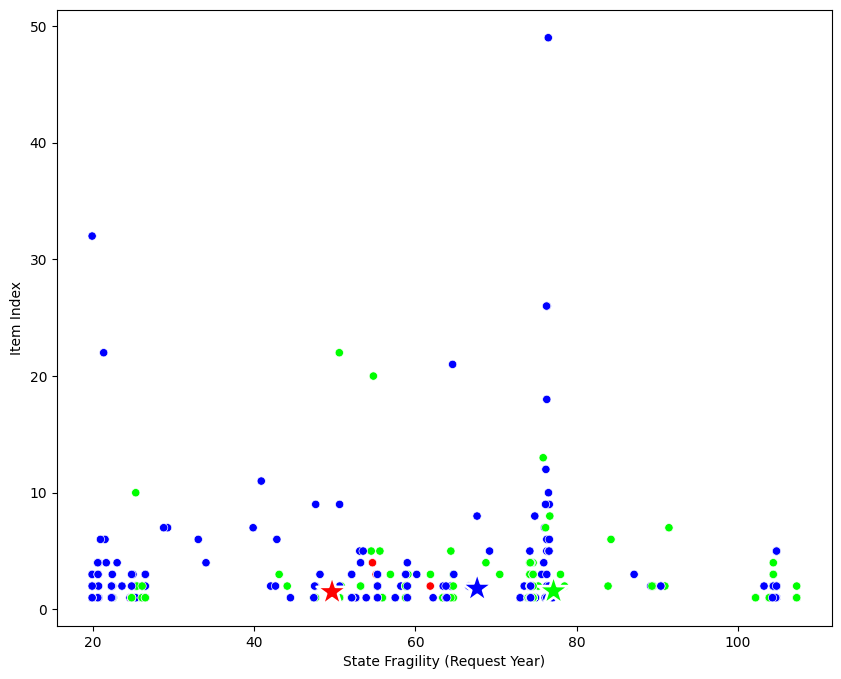

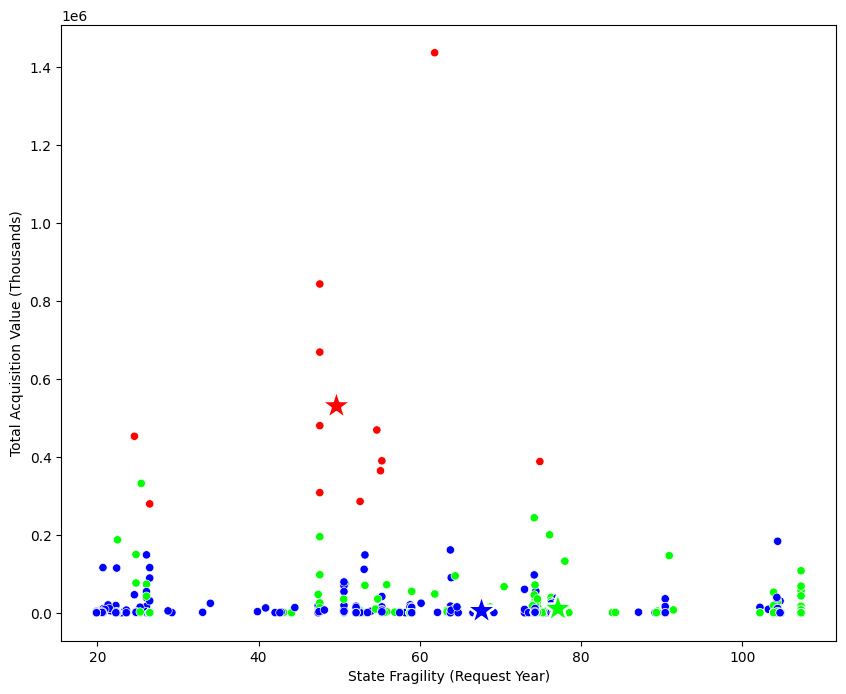

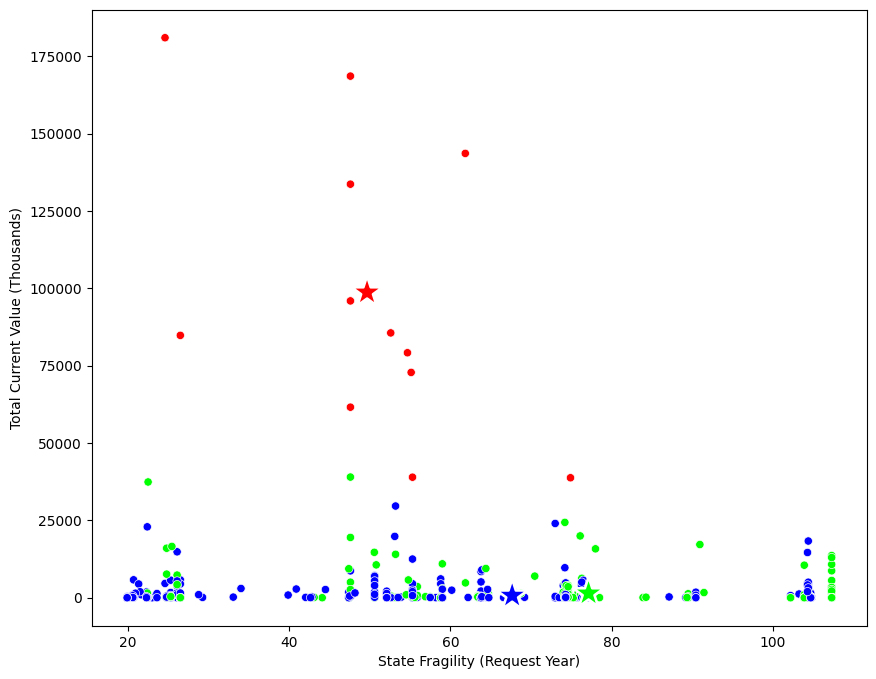

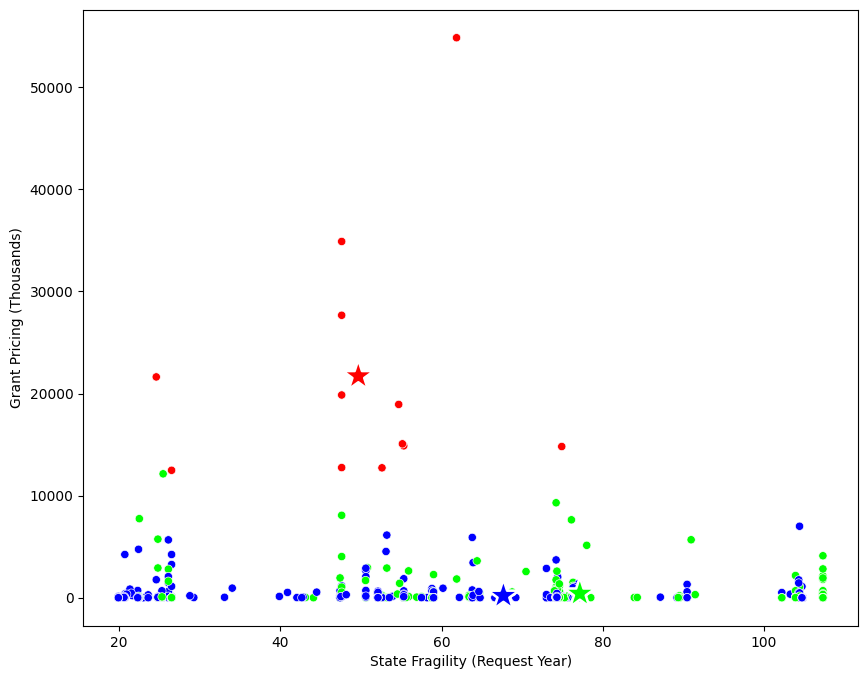

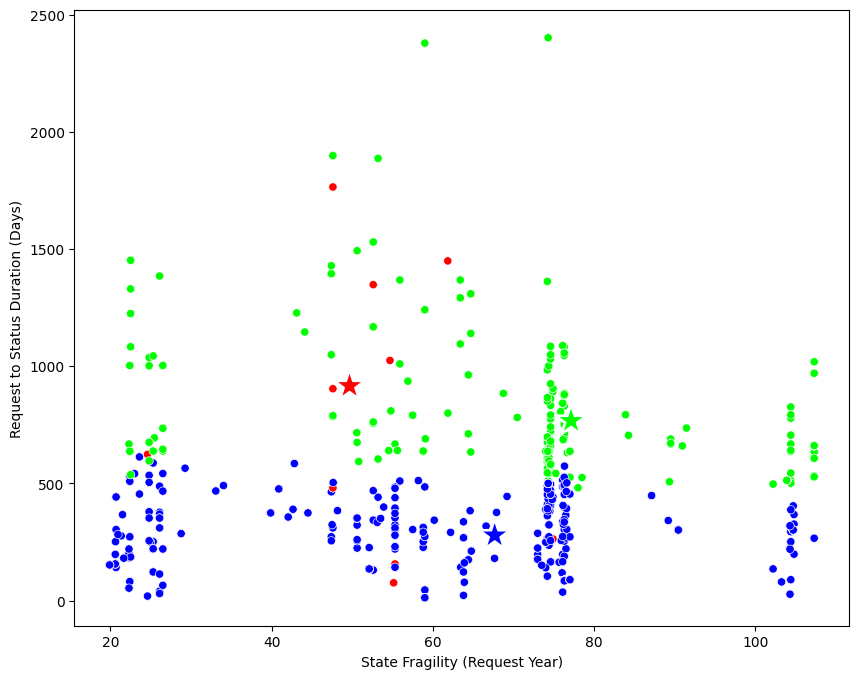

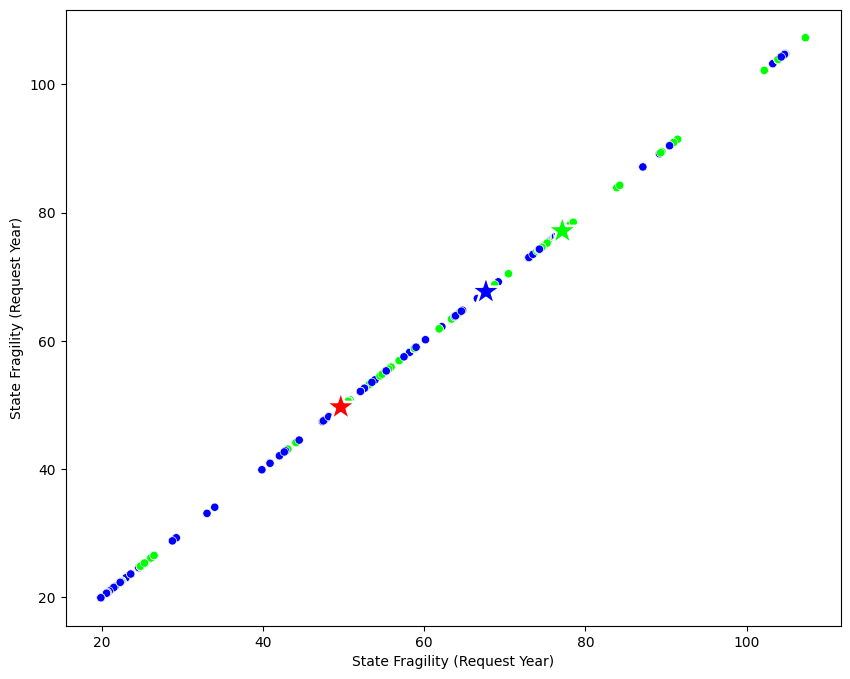

In [54]:
# Plot Clusters by selected column(x)

for col in df_with_clusters.columns[:-1]:
  plot_centroids(df_with_clusters, x=x, y=col, centroids=centroids)

#### Export dataset with clusters

In [55]:
df_with_clusters.to_csv(f'clustered_eda.csv')